In [13]:
import numpy as np
import control
from control.matlab import *
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0




In [14]:
import pickle as pkl

with open('../data/control/test_set_simple_example_1.pkl', 'rb') as f:
    test_set = pkl.load(f)

data_test = test_set['data_test']
from control.matlab import *

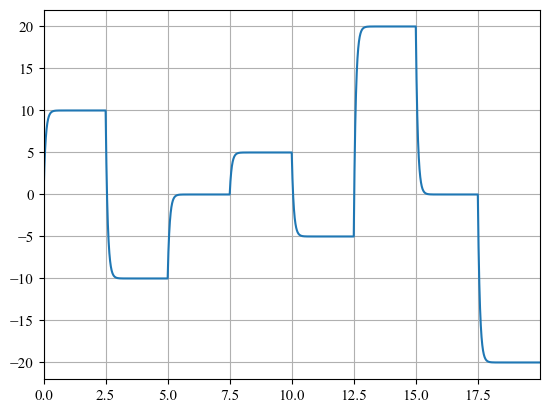

In [15]:
ts = 1e-2
T = 20
t_CL = np.arange(0, T, ts)

# VRFT
s = tf('s')
z = tf([1, 0], [1], dt=ts)
tau = 0.5# s
M = 1/(1 + (tau/(2*np.pi))*s)
M = c2d(M, ts, 'matched')

r = np.zeros(t_CL.shape)
r[t_CL < 10] = 10
r[(t_CL >= 2.5) & (t_CL < 5)] = -10
r[(t_CL >= 5.0) & (t_CL < 7.5)] = 0
r[(t_CL >= 7.5) & (t_CL < 10)] = 5
r[(t_CL >= 10.) & (t_CL < 12.5)] = -5
r[(t_CL >= 12.5) & (t_CL < 15.)] = 20
r[(t_CL >= 15.0) & (t_CL < 17.5)] = 0
r[(t_CL >= 17.5) & (t_CL < 20.0)] = -20

y_d = lsim(M,r, t_CL)[0]
plt.plot(t_CL, y_d)

t = np.arange(0, T, ts)
u = np.random.normal(0, 1000, t.shape)

In [16]:
import cvxpy as cp

B = [tf([1], [1], dt=ts),
     tf(ts * np.array([1, 1]), 2 * np.array([1, -1]), dt=ts),
     tf(np.array([2, -2]), ts * np.array([3, -1]), dt=ts)]

In [17]:
n_testing = 50
controllers = [None] * n_testing
Y_CL = np.zeros((n_testing, len(t_CL)))
U = np.zeros((n_testing, len(u)))
E = np.zeros((n_testing, len(t_CL)))
Mr_E = np.zeros((n_testing, len(t_CL)))

In [18]:
for n_testing in range(n_testing): #len(data_test)):
        
        print(n_testing)
        data = data_test[n_testing]
        # system
        num = [data['num_1']]
        den = [data['den_1'], data['den_2'], data['den_3']]
        
        G_continuous = tf(num,den)
        G = c2d(G_continuous, ts, 'matched')
        G_proper = z**2*G
        
        #first experiment
        u = np.random.normal(0, 1000, t.shape)
        y0, t, _ = lsim(G_proper, u, t)
        noise1 = np.random.normal(0, 3, t.shape)
        #y = y0 
        y = y0 #+ noise1
        
        L = M
        u_L = lsim(L,u,t)[0]
        y_L = lsim(L,y,t)[0]
        
        ## virtual reference
        M_proper = z*M
        r_v = lsim(M_proper**(-1), y_L, t)[0]
        e_v = r_v - y_L
        
        #second experiment
        #u2 = np.random.normal(0, 1000, t.shape)
        #noise2 = np.random.normal(0, 5, t.shape)
        #u2 = lsim(M, u, t)[0]
        #y2, t, _ = lsim(G, u2, t)
        #y2 = y2 + noise2

        ##instrumental variable
        #r_v_iv = lsim(M**(-1), y2, t)[0]
        #iv = r_v_iv - y2
        
    
        theta = cp.Variable(3)
        u_theta = theta[0] * lsim(B[0], e_v, t)[0] + theta[1] * lsim(B[1], e_v, t)[0] + theta[2] * lsim(B[2], e_v, t)[0]
        
        #cost = 1 / len(u) * cp.multiply(iv,(u_L - u_theta)) 
        cost = u_L - u_theta
        cost = cp.sum_squares(cost)
        prob = cp.Problem(cp.Minimize(cost))
        prob.solve()
        theta_sol = theta.value
        C = theta_sol[0]*B[0] + theta_sol[1]*B[1] + theta_sol[2]*B[2]
        
        
        F = C*G/(1 + C*G)
        y_cl = lsim(F,r,t_CL)[0]
        
        controllers[n_testing] = C
        Y_CL[n_testing] = y_cl
        U[n_testing] = u
        E[n_testing] = r - y_cl
        Mr_E[n_testing] = y_d - y_cl

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


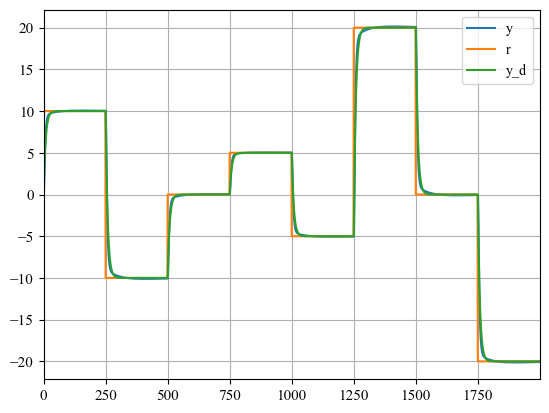

In [19]:
plt.plot( Y_CL[38], label='y')
plt.plot( r, label='r')
plt.plot(y_d, label='y_d')
plt.legend()
plt.show()

In [20]:
## CALCULATE MSE (r, y) 
error_tot = 0
for i in range(n_testing):
     for k in range(len(E[i])):
        squared_error = E[i,k] * E[i,k]
        error_tot += squared_error
         
MSE = error_tot / (len(E[0]) * (n_testing+1))
print(f"MSE (r,y): {MSE:.5f}")


Mr_error_tot = 0
for i in range(n_testing):
     for k in range(len(Mr_E[i])):
        mr_squared_error = Mr_E[i,k] * Mr_E[i,k]
        Mr_error_tot += mr_squared_error
         
MSE2 = Mr_error_tot / (len(Mr_E[0]) * (n_testing+1))
print(f"MSE  (y_d,y): {MSE2:.5f}")


# relative error, in percentage
#relative_error = 0
#counter_discarded_points = 0
#for i in range(n_testing) :
 #   for k in range(len(E[i])):
 #       e_abs = np.abs(E[i,k])
 #       ref_abs = (np.abs(r[k]))
 #       e_rel = e_abs / ref_abs
 #       if e_rel < 20 : # samples that are too big are caused by divisions by zero, unwanted, also non-converging examples are discarded
 #           relative_error += e_rel
 #       else : counter_discarded_points += 1
#re = relative_error/ (( len(E[0]) * (n_testing+1)) - counter_discarded_points) * 100

#print(f"Relative Error: {re:.2f}%")

MSE (r,y): 5.00220
MSE  (y_d,y): 0.13819


/tmp/ipykernel_185945/3717223286.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  e_rel = e_abs / ref_abs
/tmp/ipykernel_185945/3717223286.py:29: RuntimeWarning: invalid value encountered in scalar divide
  e_rel = e_abs / ref_abs


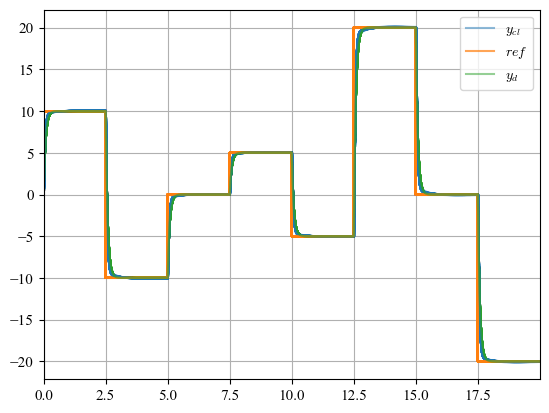

In [21]:
 for i in range(n_testing):
    plt.plot(t_CL,  Y_CL[i], c='tab:blue', alpha=0.5)
    plt.plot(t_CL, r, label='ref',c='tab:orange', alpha = 0.7)
    plt.plot(t_CL,  y_d, c='tab:green', alpha=0.5)
    plt.legend(['$y_{cl}$', '$ref$', '$y_d$'])
    plt.grid(True)
plt.show()

#0,33